In [1]:
import glob

import numpy as np
import scipy.optimize as op

import matplotlib.pyplot as plt
import matplotlib as mpl

import astropy.units as u

import emcee

from dust_extinction.averages import G03_SMCBar
from dust_extinction.parameter_averages import G23

from measure_extinction.stardata import StarData
from measure_extinction.extdata import ExtData
from measure_extinction.modeldata import ModelData
from measure_extinction.utils.fit_model import FitInfo

from measure_extinction.utils.helpers import get_full_starfile
from measure_extinction.utils.fit_model import get_best_fit_params, get_percentile_params

Specify the location of the model and observed data

In [2]:
file_path = "/home/kgordon/Python/extstar_data/"

Define star specific parameters

In [3]:
starname = "2massj181129"
fstarname = f"{starname}.dat"
velocity = 0.0 
relband = "V"

Read in the star data

In [4]:
# get the observed reddened star data
reddened_star = StarData(fstarname, path=f"{file_path}/DAT_files/")
band_names = reddened_star.data["BAND"].get_band_names()
data_names = reddened_star.data.keys()

In [5]:
# only fit the blue region
#del reddened_star.data["STIS"]
#gvals = (reddened_star.data["STIS_Opt"].waves < 0.3 * u.micron) | (reddened_star.data["STIS_Opt"].waves > 0.55 * u.micron)
#reddened_star.data["STIS_Opt"].npts[gvals] = 0

# crop the ends, often a bad
reddened_star.data["STIS_Opt"].npts[0:30] = 0
if "STIS" in reddened_star.data.keys():
    reddened_star.data["STIS"].npts[0:220] = 0
    reddened_star.data["STIS"].npts[-100:-1] = 0

Plot the spectrum

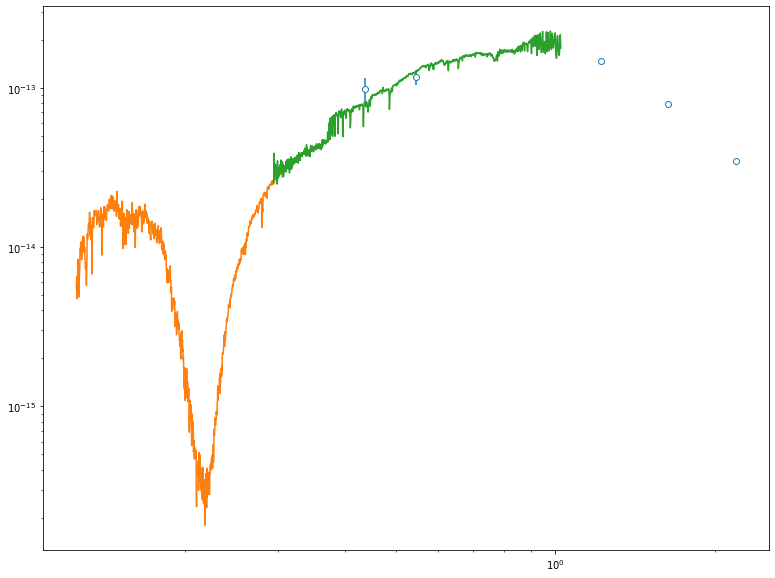

In [6]:
fig, ax = plt.subplots(figsize=(13, 10))
reddened_star.plot(ax)
ax.set_xscale("log")
ax.set_yscale("log")

Get the model data

In [7]:
tlusty_models_fullpath = glob.glob("{}/Models/tlusty_*v5.dat".format(file_path))
# tlusty_models_fullpath = tlusty_models_fullpath[0:10]
tlusty_models = [
    tfile[tfile.rfind("/") + 1 : len(tfile)] for tfile in tlusty_models_fullpath
]

# get the models with just the reddened star band data and spectra
modinfo = ModelData(
    tlusty_models,
    path="{}/Models/".format(file_path),
    band_names=band_names,
    spectra_names=data_names,
)

Setup the fit parameters

In [8]:
# parameter names
pnames = ["logT","logg","logZ","Av","Rv","C2","C3","C4","x0","gamma","HI_gal","HI_mw"]

# initial starting position
#  **customize for each star**
params = [4.3, 4.0, 0.0, 4.5, 3.1, 1.0, 3.0, 0.1, 4.66, 0.86, 10.5, 19.0]

# min/max allowed values for each parameter
# some are based on the min/max of the stellar atmosphere grid
plimits = [
        [modinfo.temps_min, modinfo.temps_max],  # log(Teff)
        [modinfo.gravs_min, modinfo.gravs_max],  # log(g)
        [modinfo.mets_min, modinfo.mets_max],    # log(Z)
        [0.0, 10.0],   # Av
        [2.31, 5.59],   # Rv
        [-0.1, 5.0],  # C2
        [0.0, 5.0],   # C3
        [0.0, 1.0],   # C4
        [4.5, 4.9],   # xo
        [0.6, 1.5],   # gamma
        [10.0, 11.0], # log(HI) internal to galaxy
        [17.0, 22.0], # log(HI) MW foreground
    ]

# add Gaussian priors based on prior knowledge
#  sptype -> log(Teff), log(g)
#  galaxy metallicity -> log(Z)
ppriors = {}
#ppriors["logT"] = (params[0], 0.01)
#ppriors["logg"] = (3.1, 0.1)
ppriors["logZ"] = (-0.1, 0.1)

Create the weight arrays based on the observed uncertainties

In [9]:
# cropping info for weights
#  bad regions are defined as those were we know the models do not work
#  or the data is bad
ex_regions = [
    [8.23 - 0.1, 8.23 + 0.1],  # geocoronal line
    [8.7, 10.0],  # bad data from STIS
    [3.55, 3.6],
    [3.80, 3.90],
    [4.15, 4.3],
    [6.4, 6.6],
    [7.1, 7.3],
    [7.45, 7.55],
    [7.65, 7.75],
    [7.9, 7.95],
    [8.05, 8.1],
] / u.micron

weights = {}
for cspec in data_names:
    weights[cspec] = np.full(len(reddened_star.data[cspec].fluxes), 0.0)
    gvals = reddened_star.data[cspec].npts > 0

    weights[cspec][gvals] = 1.0 / reddened_star.data[cspec].uncs[gvals].value

    x = 1.0 / reddened_star.data[cspec].waves
    for cexreg in ex_regions:
        weights[cspec][np.logical_and(x >= cexreg[0], x <= cexreg[1])] = 0.0

# make the photometric bands have higher weight
#weights["BAND"] *= 10000.0

Package the fit info needed.  FitInfo class defines the likelihood functions as well.

In [10]:
fitinfo = FitInfo(
    pnames,
    plimits,
    weights,
    parameter_priors=ppriors,
    stellar_velocity=velocity,
)

In [11]:
# check that the initial starting position returns a valid value of lnprob and is within the parameter bounds
fitinfo.check_param_limits(params)
print(fitinfo.lnlike(params, reddened_star, modinfo))
print(fitinfo.lnprior(params))
print(fitinfo.lnprob(params, reddened_star, modinfo, fitinfo))

-3400191.1685863826
-0.5
-3400191.6685863826


Useful function to plot data and model for specificed parameters

In [12]:
def plot_data_model(reddened_star, modinfo, params,
                    xrange=None, yrange=None):

    # intrinsic sed
    modsed = modinfo.stellar_sed(params[0:3], velocity=velocity)

    # dust_extinguished sed
    ext_modsed = modinfo.dust_extinguished_sed(params[3:10], modsed)

    # hi_abs sed
    hi_ext_modsed = modinfo.hi_abs_sed(
        params[10:12], [velocity, 0.0], ext_modsed
    )

    # create a StarData object for the best fit SED
    #modsed_stardata = modinfo.SED_to_StarData(modsed)

    norm_model = np.average(hi_ext_modsed["BAND"])
    norm_data = np.average(reddened_star.data["BAND"].fluxes).value

    # plotting setup for easier to read plots
    fontsize = 18
    font = {"size": fontsize}
    mpl.rc("font", **font)
    mpl.rc("lines", linewidth=1)
    mpl.rc("axes", linewidth=2)
    mpl.rc("xtick.major", width=2)
    mpl.rc("xtick.minor", width=2)
    mpl.rc("ytick.major", width=2)
    mpl.rc("ytick.minor", width=2)

    # setup the plot
    fig, ax = plt.subplots(figsize=(13, 10))

    # plot the bands and all spectra for this star
    for cspec in modinfo.fluxes.keys():
        if cspec == "BAND":
            ptype = "o"
        else:
            ptype = "-"

        # ax.plot(reddened_star.data[cspec].waves,
        #        weights[cspec], 'k-')

        ax.plot(
            reddened_star.data[cspec].waves,
            reddened_star.data[cspec].fluxes,
            "k" + ptype,
            label="data",
        )

        # print(reddened_star.data[cspec].waves)
        # print(modinfo.waves[cspec])

        ax.plot(
            modinfo.waves[cspec], modsed[cspec] * norm_data / norm_model, "b" + ptype, label=cspec
        )
        ax.plot(
            modinfo.waves[cspec],
            ext_modsed[cspec] * norm_data / norm_model,
            "r" + ptype,
            label=cspec,
        )
        ax.plot(
            modinfo.waves[cspec],
            hi_ext_modsed[cspec] * norm_data / norm_model,
            "g" + ptype,
            label=cspec,
        )

    # finish configuring the plot
    if xrange is not None:
        ax.set_xlim(xrange)
    if yrange is not None:
        ax.set_ylim(yrange)
    else:
        ax.set_ylim(2.0 * norm_data / norm_model, 8e9 * norm_data / norm_model)
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_xlabel(r"$\lambda$ [$\mu m$]", fontsize=1.3 * fontsize)
    ax.set_ylabel(r"$F(\lambda)$ [$ergs\ cm^{-2}\ s\ \AA$]", fontsize=1.3 * fontsize)
    ax.tick_params("both", length=10, width=2, which="major")
    ax.tick_params("both", length=5, width=1, which="minor")

    # ax.legend()

    # use the whitespace better
    fig.tight_layout()

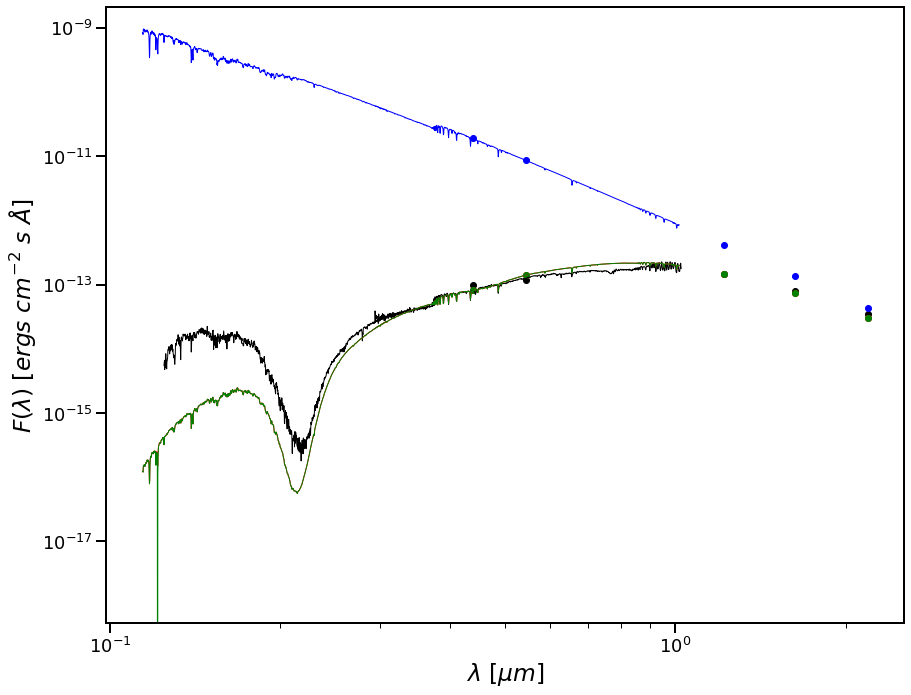

In [13]:
# plot initial guess
plot_data_model(reddened_star, modinfo, params)

In [14]:
# simple function to turn the log(likelihood) into the chisqr
#  requied as op.minimize function searchs for the minimum chisqr (not max likelihood like MCMC algorithms)
def nll(*args):
    return -fitinfo.lnprob(*args)

# run the fit
result = op.minimize(
    nll, params, method="Nelder-Mead", options={"maxiter": 5000}, args=(reddened_star, modinfo, fitinfo)
)

# check the fit output
print(result["message"])

Optimization terminated successfully.


In [15]:
# save results
params = result["x"]
fit_params = params
params_best = params
pnames_extra = pnames

# print the best fit
for k, val in enumerate(params_best):
    print("{} # {}".format(val, pnames_extra[k]))


4.247879790571799 # logT
3.9769455946213235 # logg
0.00024751675779723466 # logZ
4.6975013256073614 # Av
3.7503829464810896 # Rv
0.9310564743342126 # C2
2.692059384257739 # C3
0.09491919957466083 # C4
4.60029235758083 # x0
0.8945253631265225 # gamma
10.727436741460892 # HI_gal
18.025734407063865 # HI_mw


Calculate and save the extinction curve

In [16]:
# intrinsic sed
modsed = modinfo.stellar_sed(fit_params[0:3], velocity=velocity)

# dust_extinguished sed
ext_modsed = modinfo.dust_extinguished_sed(fit_params[3:10], modsed)

# hi_abs sed
hi_ext_modsed = modinfo.hi_abs_sed(
    fit_params[10:12], [velocity, 0.0], ext_modsed
)

# create a StarData object for the best fit SED
modsed_stardata = modinfo.SED_to_StarData(modsed)

# create an extincion curve and save it
extdata = ExtData()
extdata.calc_elx(reddened_star, modsed_stardata, rel_band=relband)
col_info = {"av": fit_params[3], "rv": fit_params[4]}
extdata.save(starname + "_ext.fits", column_info=col_info)

Plot the spectra

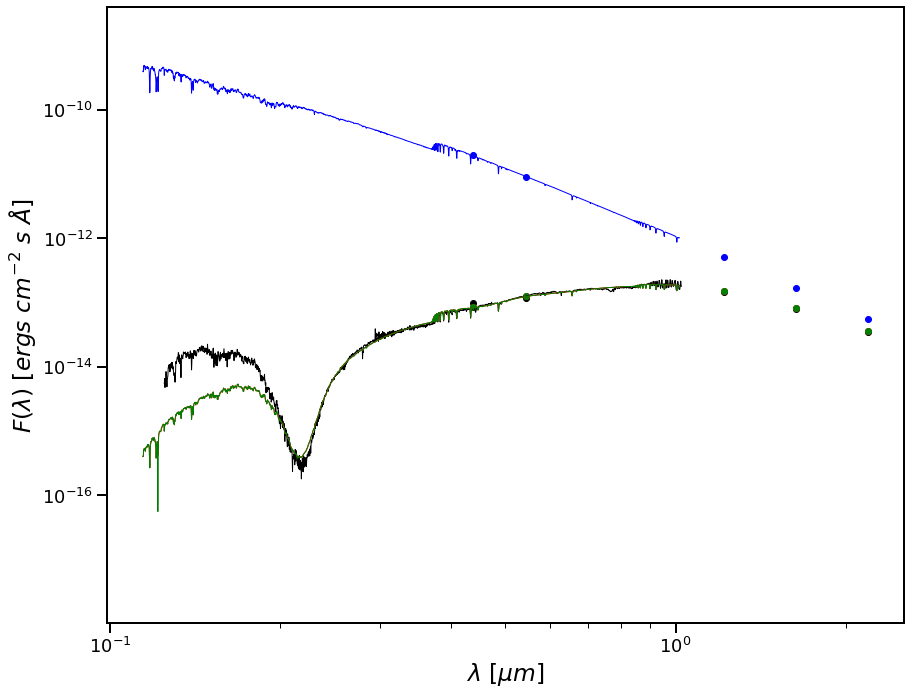

In [17]:
# plot optimizer/minimizer best fit
plot_data_model(reddened_star, modinfo, params)

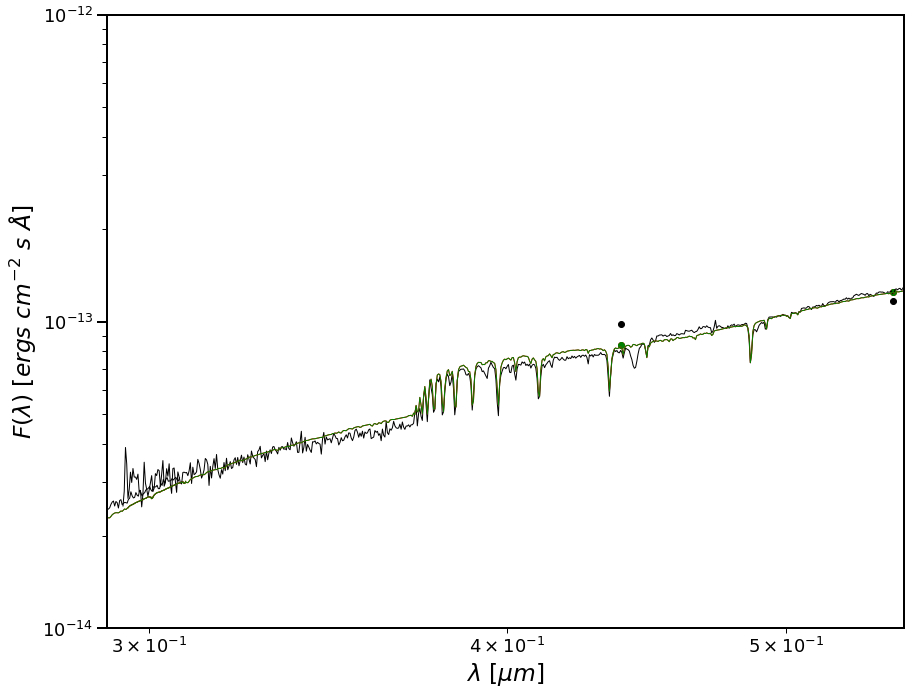

In [18]:
plot_data_model(reddened_star, modinfo, params, yrange=[1e-14, 1e-12], xrange=[0.29, 0.55])

Function to plot extinction curve

In [19]:
def plot_ext(extdata):
    fontsize = 18
    
    fig, ax = plt.subplots(figsize=(13, 10))

    # convert from E(l-V) to A(l)/A(V)
    extdata.columns["AV"] = (params[3], 0.0)
    extdata.trans_elv_alav()

    extdata.plot(ax) #, alax=True)
    ax.set_xscale("log")
    ax.set_xlabel(r"$\lambda$ [$\mu m$]", fontsize=1.3 * fontsize)
    ax.set_ylim(0.0, 10.0)
    ax.set_ylabel(r"$A(\lambda)/A(V)$", fontsize=1.3 * fontsize)
    ax.tick_params("both", length=10, width=2, which="major")
    ax.tick_params("both", length=5, width=1, which="minor")

    # plot known exitnction curves
    mod_x = np.arange(0.3, 8.7, 0.1) / u.micron
    smcbar = G03_SMCBar()
    ax.plot(1.0 / mod_x, smcbar(mod_x), "k:")

    g23_rv31 = G23(Rv=3.1)
    ax.plot(1.0 / mod_x, g23_rv31(mod_x), "k-")

Plot the extinction curve

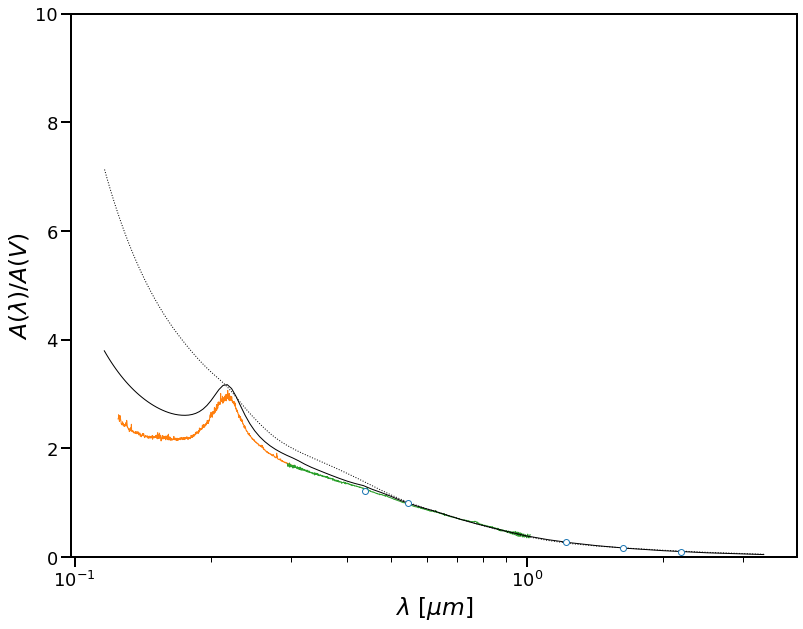

In [20]:
plot_ext(extdata)

Run emcee MCMC sampler to define uncertainties (bonus section)

In [21]:
p0 = params
ndim = len(p0)

#nwalkers = 2 * ndim
#nsteps = 50
#burn = 50

nwalkers = 100
nsteps = 500
burn = 500

# setting up the walkers to start "near" the inital guess
p = [p0 * (1 + 0.01 * np.random.normal(0, 1.0, ndim)) for k in range(nwalkers)]

# setup the sampler
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, fitinfo.lnprob, args=(reddened_star, modinfo, fitinfo)
)

# burn in the walkers
pos, prob, state = sampler.run_mcmc(p, burn)

# rest the sampler
sampler.reset()

# do the full sampling
pos, prob, state = sampler.run_mcmc(pos, nsteps, rstate0=state)

# create the samples variable for later use
samples = sampler.chain.reshape((-1, ndim))

# get the best fit values
pnames_extra = pnames + ["E(B-V)", "N(HI)/A(V)", "N(HI)/E(B-V)"]
params_best = get_best_fit_params(sampler)
fit_params = params_best
print("best params")
print(params_best)

# get the 16, 50, and 84 percentiles
params_per = get_percentile_params(samples)

# save the best fit and p50 +/- uncs values to a file
# save as a single row table to provide a uniform format
#f = open(out_basename + "_fit_params.dat", "w")
#f.write("# best fit, p50, +unc, -unc\n")
for k, val in enumerate(params_per):
    print(
        "{} {} {} {} # {}".format(
            params_best[k], val[0], val[1], val[2], pnames_extra[k]
        )
    )
#    f.write(
#        "{} {} {} {} # {}\n".format(
#            params_best[k], val[0], val[1], val[2], pnames_extra[k]
#        )
#    )


/home/kgordon/Bin/miniconda3/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


best params
[4.22100056e+00 4.04039864e+00 2.03060620e-04 4.56779086e+00
 3.73173350e+00 4.65131357e-01 3.21286585e+00 1.17964763e-01
 4.60146223e+00 8.39197941e-01 1.03118897e+01 1.83405052e+01
 1.22403994e+00 4.48935035e+09 1.67530591e+10]
4.2210005592368525 4.222346301753886 0.006272339768301549 0.005203441814288112 # logT
4.040398642019923 3.9656463770384103 0.12112550228022867 0.09601174005794855 # logg
0.00020306062038010826 0.00022588966446286128 1.7298352656137673e-05 9.21876547043364e-06 # logZ
4.567790863564958 4.5697863179625315 0.06322688190623982 0.0016428710965685767 # Av
3.731733502867435 3.732255248552204 0.006495213570045344 0.001614355161988712 # Rv
0.46513135652467863 0.48080595143123034 0.0690577241606633 0.013260315155217195 # C2
3.212865846722291 3.137059584225093 0.05230329668783584 0.18824804499424497 # C3
0.11796476301367757 0.10486214865451227 0.004437969176320777 0.00290193312543377 # C4
4.601462226298249 4.592572226222481 0.01026771440182106 0.00964363055023

In [22]:
# intrinsic sed
modsed = modinfo.stellar_sed(fit_params[0:3], velocity=velocity)

# dust_extinguished sed
ext_modsed = modinfo.dust_extinguished_sed(fit_params[3:10], modsed)

# hi_abs sed
hi_ext_modsed = modinfo.hi_abs_sed(
    fit_params[10:12], [velocity, 0.0], ext_modsed
)

# create a StarData object for the best fit SED
modsed_stardata = modinfo.SED_to_StarData(modsed)

# create an extincion curve and save it
extdata = ExtData()
extdata.calc_elx(reddened_star, modsed_stardata, rel_band=relband)
col_info = {"av": fit_params[3], "rv": fit_params[4]}
extdata.save(starname + "_ext.fits", column_info=col_info)

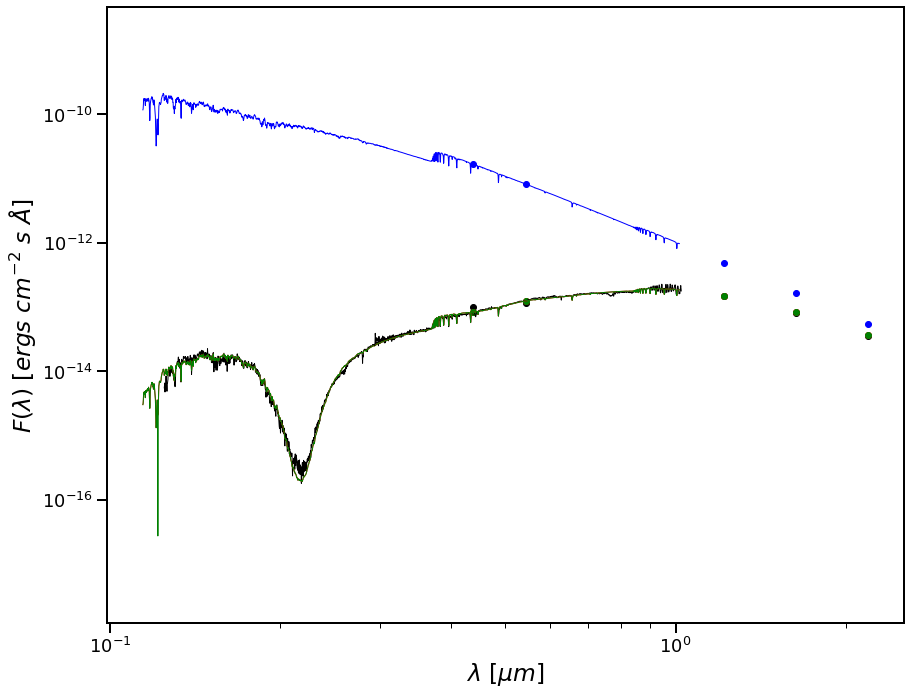

In [23]:
plot_data_model(reddened_star, modinfo, fit_params)

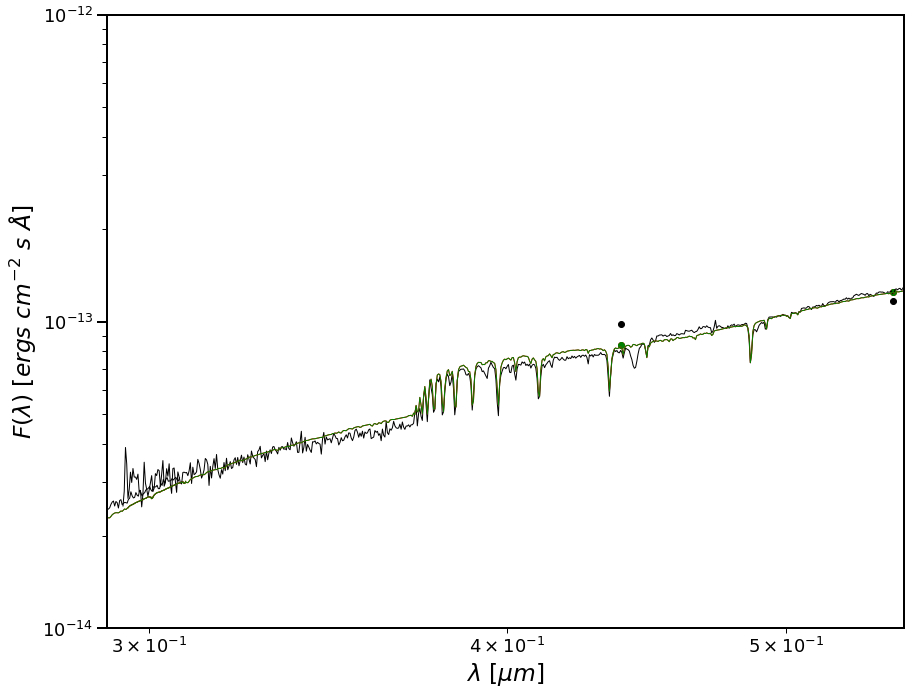

In [25]:
plot_data_model(reddened_star, modinfo, params, yrange=[1e-14, 1e-12], xrange=[0.29, 0.55])

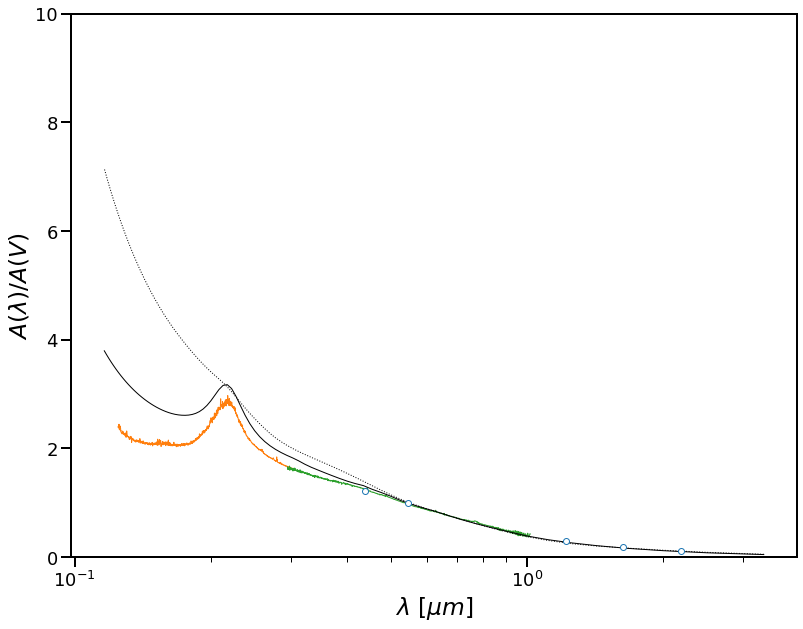

In [24]:
plot_ext(extdata)